# Efficient Frontier Implemented in Python

<b>Modern Portfolio Theory (MPT)</b> is an investment theory developed by Harry Markowitz and published under the 
title "Portfolio Selection" in the Journal of Finance in 1952.

A famous saying in finance is that <b>"there ain't no such thing as a free lunch"</b>. This concept is closely 
related to 'risk-return trade-off'.

Higher risk is associated with greater probability of higher return and lower risk with a greater probability 
of smaller return.  

MPT assumes that investors are risk-averse, i.e. given two portfolios that offer the same expected return, 
investors will prefer the less risky one. Thus, <b>an investor will take on increased risk if and only if 
compensated by higher expected returns</b>. 

Another factor comes in to play in MPT is <b>"diversification"</b>. Modern portfolio theory says that it is not 
enough to look at the expected risk and return of one particular stock. By investing in more than one stock, 
an investor can reap the benefits of diversification – chief among them, a reduction in the riskiness of the 
portfolio.

<b>"Risk of a portfolio is not equal to average/weighted-average of individual stocks in the portfolio".</b> 

In terms of return, yes it is the average/weighted average of individual stock's returns, but 
that's not the case for risk. The risk is about how volatile the asset is, if you have more than one stock in 
your portfolio, then you have to take count of how these stocks movement correlates with each other. The beauty of 
diversification is that you can even get lower risk than a stock with the lowest risk in your portfolio, by 
optimizing the allocation. 

## IMPORTANT

First, let's start by importing some libraries we need.
 
"Quandl" is a financial platform which also offers Python library. One needs to first install the package in 
your command line "pip install quandl", before it can be used.

Also, one needs to get an API key on Quandl's website. Sign-up and getting an API key is free but has some limits. 
As a logged-in free user, one can make 2,000 calls per 10 minutes maximum (speed limit), and 50,000 calls per 
day (volume limit). 

Go to https://www.quandl.com/ and get a API key.

In [189]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quandl
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [190]:
allow_short_positions = False
quandl.ApiConfig.api_key = 'ehDLi-_7WUZ4UQR_9Zhe'
stocks = ['AAPL','AMZN','GOOGL','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2016-1-1', 'lte': '2017-12-31' }, paginate=True)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 3 columns):
date         2006 non-null datetime64[ns]
ticker       2006 non-null object
adj_close    2006 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 39.2+ KB


In [191]:
df = data.set_index('date')
df.head()

# making stock names the column names
table = df.pivot(columns='ticker')
table.columns = [col[1] for col in table.columns]
table.head()

,AAPL,AMZN,FB,GOOGL
date,,,,
2016-01-04,101.783763,636.99,102.22,759.44
2016-01-05,99.233131,633.79,102.73,761.53
2016-01-06,97.291172,632.65,102.97,759.33
2016-01-07,93.185040,607.94,97.92,741.00
2016-01-08,93.677776,607.05,97.33,730.91


## Stock Time Series

Text(0, 0.5, 'Price (USD)')

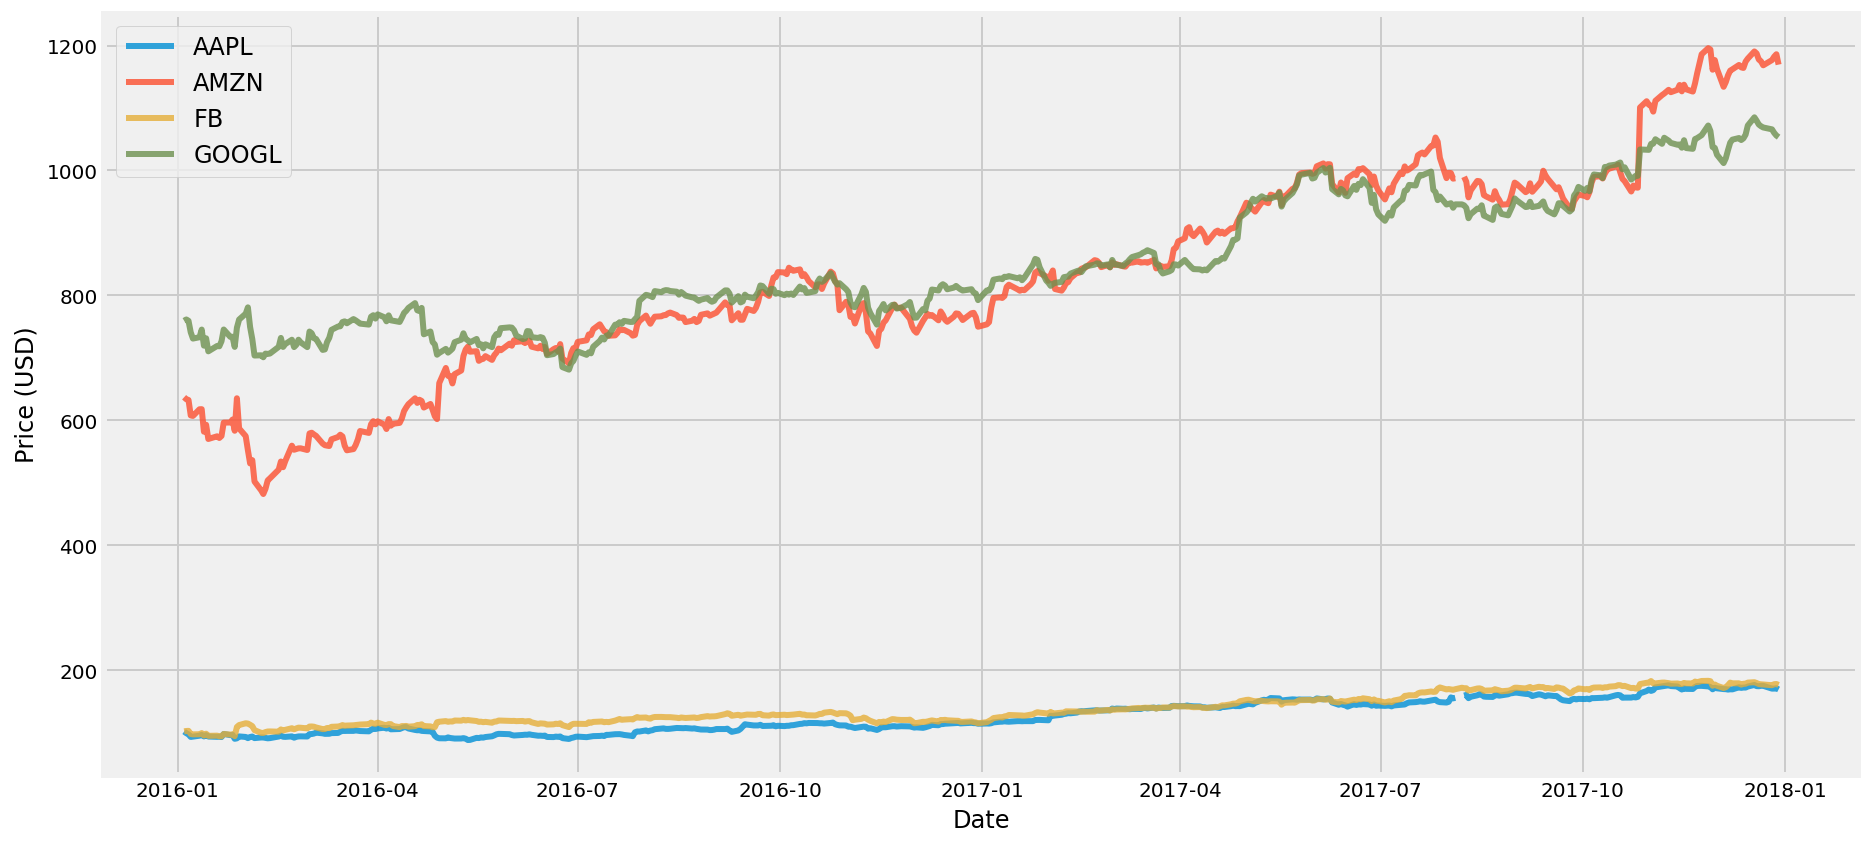

In [192]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Price (USD)')

Amazon and Google's stock price is relatively more expensive than those of Facebook and Apple.

Plotting daily returns (percent change compared to the day before). By plotting daily returns instead of
actual prices, one can see a stock's volatility.

Text(0, 0.5, 'Daily Returns')

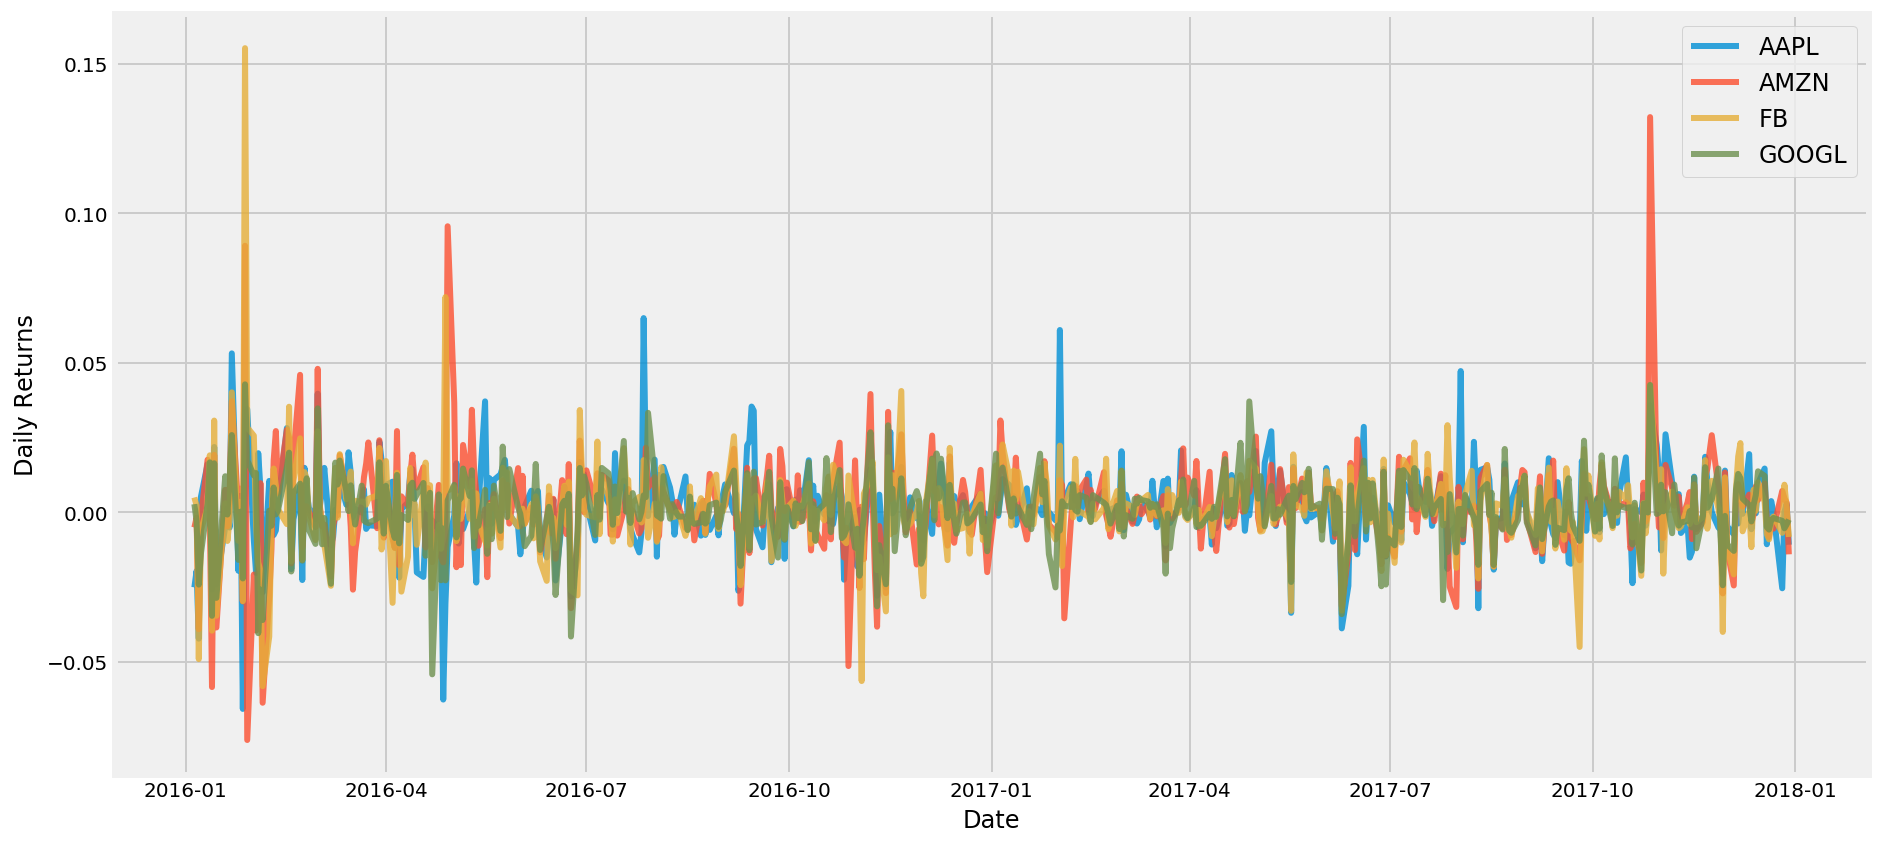

In [193]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8, label=c)
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Daily Returns')

Amazon has two distinctive positive spikes and a couple of negative ones. Facebook has one highest positive spike. 
And Google seems to be the least volatile.

## Random Portfolios Generation

## How to allocate a budget to each of stock in our portfolio. 

If our total budget is 1, then we can decide the weights for each stock, so that the sum of weights will be 1. 

And the value for weights will be the portion of budget we allocate to a specific stock.  For example, if 
weight is 0.5 for Amazon, it means that we allocate 50% of our budget to Amazon.

Let's define some functions to simulate random weights to each stock in the portfolio, then calculate the 
portfolio's overall annualized returns and annualized volatility.

<b>Portfolio_annual_performance</b> function will calculate the returns and volatility, and to make it as an 
annualized calculation, remember that that there are 252 trading days in one year. 

<b>Random_portfolios</b> function will generate portfolios with random weights assigned to each stock, 
and by passing num_portfolios argument, it will decide how many random portfolios you want to generate.

In [194]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        if not allow_short_positions:
            weights = np.random.uniform(low=0.0, high=1.0, size=len(stocks))
        else:
            weights = np.random.uniform(low=-1.0, high=1.0, size=len(stocks))
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

## Generate 25,000 portfolios with random weights assigned to each stock.

In [195]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.0178

First, it generates random portfolio and gets the results (portfolio returns, portfolio volatility, 
portfolio Sharpe ratio) and weights for the corresponding result.
 
Then by locating the one with the highest Sharpe ratio portfolio, it displays maximum Sharpe ratio portfolio 
as red star sign. And does similar steps for minimum volatility portfolio, and displays it as the green star on the 
plot. All the randomly generated portfolios will be also plotted with color map applied to them based 
on the Sharpe ratio. The bluer, the higher Sharpe ratio.

And for these two optimal portfolios, it will also show how it allocates the budget within the portfolio.

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.6903
Annualized Volatility: 0.4165

             AAPL   AMZN     FB  GOOGL
allocation  99.78  79.41  78.53 -50.61
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: -0.0025
Annualized Volatility: 0.013

            AAPL  AMZN    FB  GOOGL
allocation  4.88 -4.89  1.93  -2.94
--------------------------------------------------------------------------------


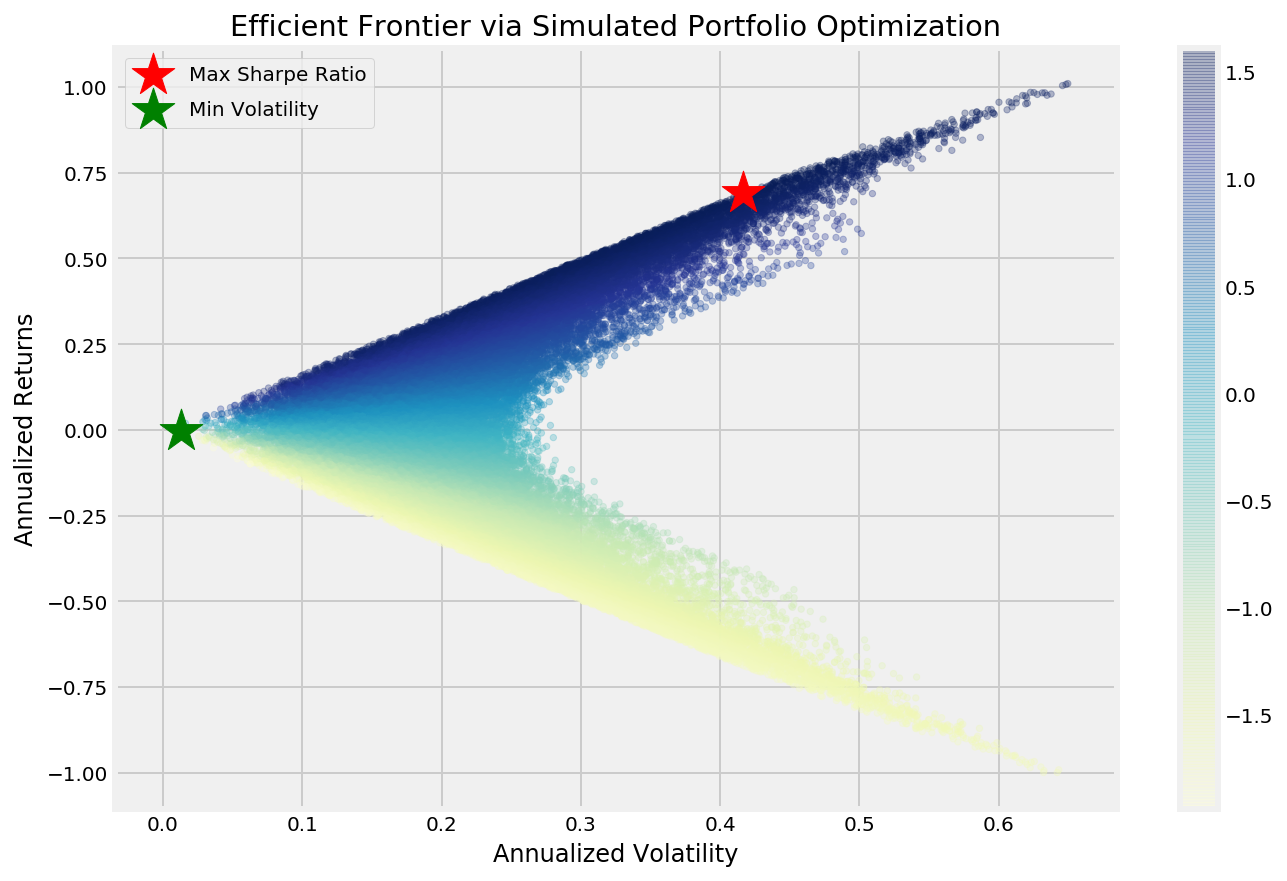

In [196]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualized Return:", round(rp,4))
    print("Annualized Volatility:", round(sdp,4))
    print()
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualized Return:", round(rp_min,4))
    print("Annualized Volatility:", round(sdp_min,4))
    print()
    print(min_vol_allocation)
    print("-"*80)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Max Sharpe Ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Min Volatility')
    plt.title('Efficient Frontier via Simulated Portfolio Optimization')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Returns')
    plt.legend(labelspacing=0.8)
    
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)


For the minimum volatility portfolio, more than half of our budget is allocated to Google. From the daily return 
plot, Google is the least volatile stock of the four stocks shown, so allocating a large percentage to Google 
for minimum risk portfolio makes intuitive sense.

If one is willing to take more risk for a higher return, one could take the best risk-adjusted return which is the 
portfolio with the maximum Sharpe ratio. In this scenario, we are allocating a significant portion to Amazon and 
Facebook, which are quite volatile stocks from the previous plot of daily returns. And Google which had more than 50% 
allocation in the minimum risk portfolio, has less than 1% budget allocated to it.

## Efficient Frontier

From the plot of the randomly simulated portfolio, one can see it forms a shape of an arch line on the top of 
clustered blue dots. This line is called <b>efficient frontier</b>. 

<b>Why is it efficient? 

Because points along the line will yield the lowest risk for a given target return</b>. 

All the other dots right to the line are higher risk with the same returns. If the expected returns 
are the same, why would you take an extra risk when there's an option with lower risk?

By randomly selecting weights, one can simulate portfolios and pick the best ones (either minimum risk or 
maximum risk-adjusted return). 

One can also do this via Python module Scipy's optimize function.  This is similiar to Excel's 'solver' function. 
Scipy's optimize function is doing the similar task when given the objective function, constraints and bounds.

Below are functions to compute the maximum Sharpe ratio portfolio. 

In Scipy's optimize function, there's no 'maximize', so as an objective function you need to pass 
something that should be minimized. That is why the first "neg_sharpe_ratio" is computing the negative Sharpe ratio. 

Now we can use this as our objective function to minimize. 

In "max_sharpe_ratio" function, one must first define arguments (this should not include the variables 
you would like to change for optimization, in this case, "weights"). 

Constraints, at first, might be difficult to understand, due to the way it is stated. 

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

The above constraint is saying that sum of x should be equal to 1. You can think of the 'fun' part construction 
as '1' on the right side of equal sign has been moved to the left side of the equal sign.

'np.sum(x) == 1' has become 'np.sum(x)-1'

And what does this mean? It simply means that the sum of all the weights should be equal to 1. You cannot 
allocate more than 100% of your budget in total.

"bounds" is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1.  
You cannot give minus budget allocation to a stock or more than 100% allocation to a stock.

In [197]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0) if allow_short_positions == False else (-1.0,1.0) 
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [198]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0) if allow_short_positions == False else (-1.0,1.0) 
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

As I already mentioned above we can also draw a line which depicts where the efficient portfolios for a given risk 
rate should be. This is called "efficient frontier". Below I define other functions to compute efficient frontier. 
The first function "efficient_return" is calculating the most efficient portfolio for a given target return, and 
the second function "efficient_frontier" will take a range of target returns and compute efficient portfolio for 
each return level.

In [199]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets)) 
    if allow_short_positions == True:
        tuple((-1,1) for asset in range(num_assets)) 
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', 
                          bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.34
Annualized Volatility: 0.2


             AAPL   AMZN     FB  GOOGL
allocation  54.35  38.25  37.86 -30.47
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 0.22
Annualized Volatility: 0.16


             AAPL  AMZN    FB  GOOGL
allocation  34.02   0.9  7.01  58.06
--------------------------------------------------------------------------------


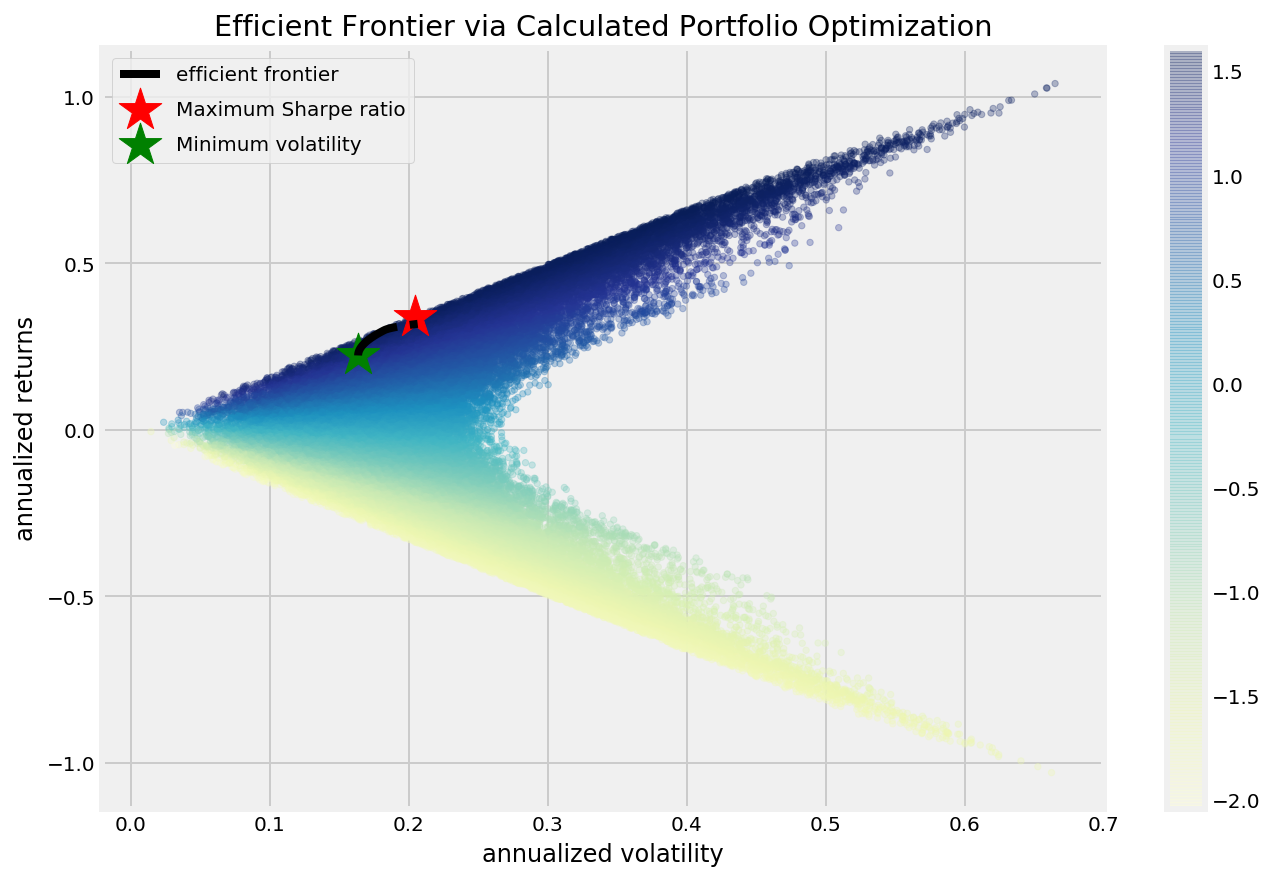

In [200]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualized_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualized_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualized Return:", round(rp,2))
    print("Annualized Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualized Return:", round(rp_min,2))
    print("Annualized Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Efficient Frontier via Calculated Portfolio Optimization')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=0.8)
    
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

Nearly the same result as the simulation of randomly generated portfolios. 

The slight difference is that the Scipy's "optimize" function has not allocated any budget at all
for Google on maximum Sharpe ratio portfolio, while one we chose from the randomly generated samples had a small 
allocation for Google. There are some differences in the decimal places but more or less same.

Thus, instead of plotting every randomly generated portfolio, one can plot individual stocks on the plot 
with the corresponding values of each stock's annual return and annual risk. This way we can see and 
compare how diversification is lowering the risk by optimising the allocation.

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.34
Annualized Volatility: 0.2


             AAPL   AMZN     FB  GOOGL
allocation  54.35  38.25  37.86 -30.47
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 0.22
Annualized Volatility: 0.16


             AAPL  AMZN    FB  GOOGL
allocation  34.02   0.9  7.01  58.06
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AAPL : annualized return 0.28 , annualized volatility: 0.21
AMZN : annualized return 0.34 , annualized volatility: 0.25
FB : annualized return 0.3 , annualized volatility: 0.23
GOOGL : annualized return 0.18 , annualized volatility: 0.18
--------------------------------------------------------------------------------


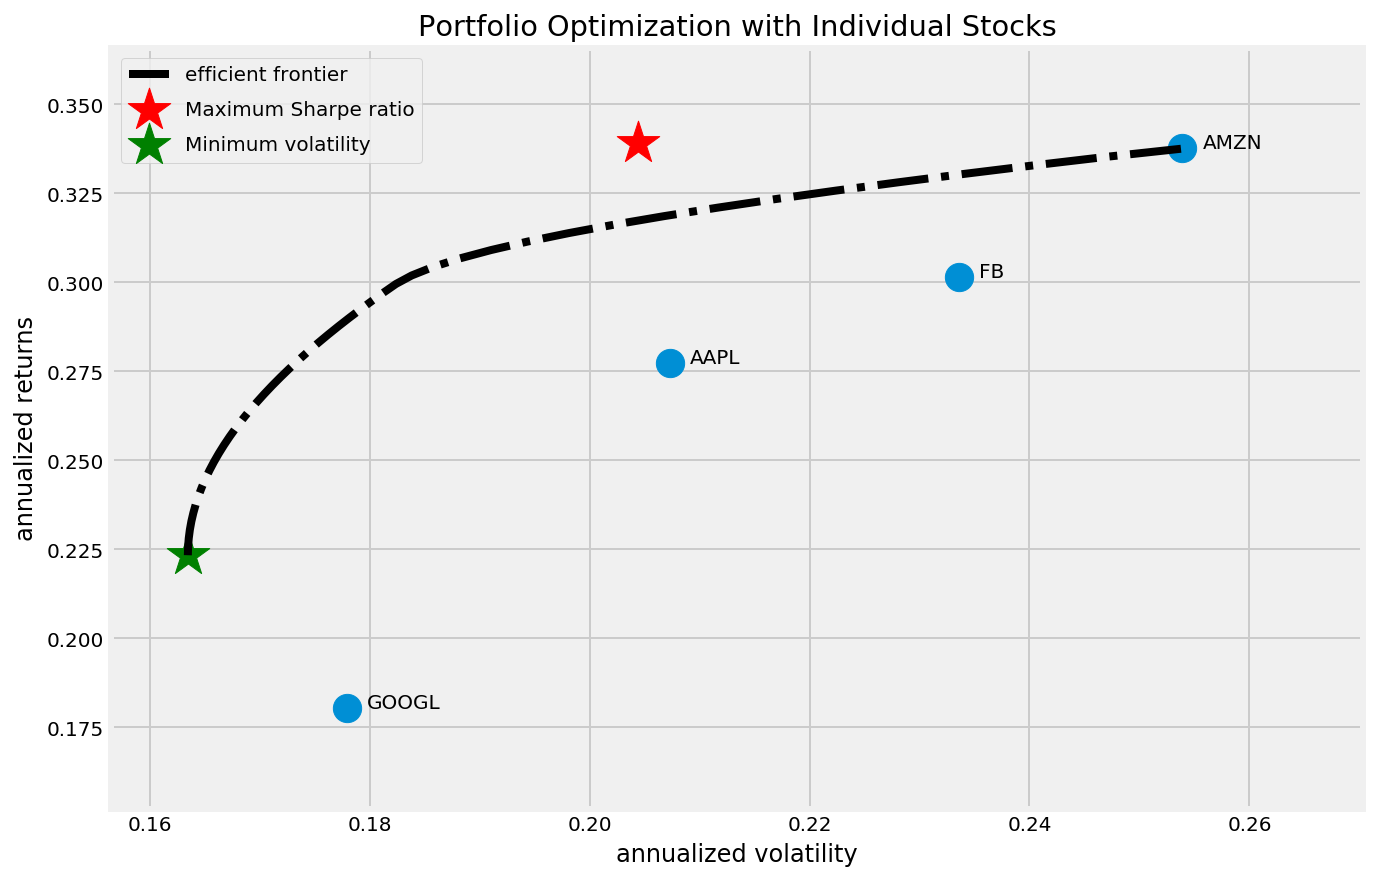

In [201]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualized_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualized_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualized Return:", round(rp,2))
    print("Annualized Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualized Return:", round(rp_min,2))
    print("Annualized Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print(txt,":","annualized return",round(an_rt[i],2),", annualized volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualized volatility')
    ax.set_ylabel('annualized returns')
    ax.legend(labelspacing=0.8)
    
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

The stock with the least risk is Google at around 0.18.  But with portfolio optimization, one can achieve an 
even lower risk at 0.16, and still with a higher return than Google. And if one is willing to take slightly 
more risk at around the similar level of risk of Google, one can achieve a much higher return of 
0.30 with portfolio optimization.
